In [17]:
import os
import re
import pandas as pd

import matplotlib.pyplot as plt

from itertools import product


In [18]:
results_path = "../outputs"

folders = os.listdir(results_path)
folders = [folder for folder in folders if 'yolo_experiment' in folder]

In [19]:
search_space = {
    "hsv_h": [0.015, 0.0],
    "hsv_s": [0.7, 0.0],
    "hsv_v": [0.4, 0.0],
    "translate": [0.1, 0.0],
    "scale": [0.5, 0.0],
    "fliplr": [0.5, 0.0],
    "mosaic": [1.0, 0.0],
    "erasing": [0.4, 0.0],
}

# key 목록과 가능한 조합 생성
keys, values = zip(*search_space.items())
combinations = [dict(zip(keys, v)) for v in product(*values)]

print(f"총 조합 수: {len(combinations)}")  # 2^8 = 256 조합

총 조합 수: 256


In [20]:

def compare_yolo_runs(run_paths, metric_keys=None, labels=None):
    """
    여러 YOLOv5 결과 파일을 비교 시각화합니다.
    
    Parameters:
    - run_paths: results.csv 파일들이 있는 경로들의 리스트
    - metric_keys: 비교할 메트릭 리스트 (기본값: 주요 메트릭)
    - labels: 각 run에 대한 레이블 이름 (None이면 디렉토리 이름 사용)
    """
    if metric_keys is None:
        metric_keys = [
            'metrics/mAP50(B)', 'metrics/mAP50-95(B)',
            'metrics/precision(B)', 'metrics/recall(B)',
            'train/box_loss', 'val/box_loss',
            'train/cls_loss', 'val/cls_loss'
        ]

    if labels is None:
        labels = [os.path.basename(os.path.normpath(p)) for p in run_paths]

    plt.figure(figsize=(15, len(metric_keys) * 4))

    for i, key in enumerate(metric_keys, 1):
        plt.subplot(len(metric_keys), 1, i)
        for path, label in zip(run_paths, labels):
            csv_file = os.path.join(path, 'results.csv')
            if not os.path.exists(csv_file):
                continue
            df = pd.read_csv(csv_file)
            if key not in df.columns:
                continue
            plt.plot(df['epoch'], df[key], label=label, marker='o')
        plt.title(f"{key}")
        plt.xlabel("Epoch")
        plt.ylabel(key)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

In [21]:
def sort_runs_by_number(run_dirs):
    """
    폴더명에서 숫자를 추출해 오름차순 정렬합니다.
    예: ['exp1', 'exp10', 'exp2'] → ['exp1', 'exp2', 'exp10']
    """
    def extract_number(s):
        match = re.search(r'(\d+)$', s)
        if match:
            return (1, int(match.group(1)))  # 숫자 있는 폴더는 두 번째 정렬 기준으로 숫자 사용
        else:
            return (0, 0)  # 숫자 없는 폴더는 가장 앞에 오도록 함

    return sorted(run_dirs, key=extract_number)

In [22]:
run_dirs = [ os.path.join(results_path, forder) for forder in folders]
run_dirs = sort_runs_by_number(run_dirs)

In [23]:
def get_top3_yolo_runs(run_dirs, sort_key="metrics/mAP50-95(B)", top_k=3, verbose=True):
    """
    여러 YOLO 학습 결과에서 best epoch 기준으로 TOP K 모델을 추출합니다.
    
    Parameters:
    - run_dirs: YOLO 학습 결과 폴더 리스트
    - sort_key: 정렬 기준 메트릭 (기본: mAP50-95)
    - top_k: 몇 개의 상위 모델을 추출할지
    - verbose: 출력 여부
    
    Returns:
    - top_k_df: 상위 K개의 결과 요약 DataFrame
    """
    results = []
    
    for run_dir in run_dirs:
        csv_path = os.path.join(run_dir, "results.csv")
        if not os.path.exists(csv_path):
            if verbose:
                print(f"[무시됨] {csv_path} 없음")
            continue
        df = pd.read_csv(csv_path)
        if sort_key not in df.columns:
            if verbose:
                print(f"[무시됨] {run_dir}: '{sort_key}' 컬럼 없음")
            continue

        best_idx = df[sort_key].idxmax()
        best_row = df.loc[best_idx]
        results.append({
            "run": os.path.basename(run_dir),
            "epoch": int(best_row["epoch"]),
            sort_key: best_row[sort_key],
            "mAP50": best_row.get("metrics/mAP50(B)", None),
            "Precision": best_row.get("metrics/precision(B)", None),
            "Recall": best_row.get("metrics/recall(B)", None),
            "box_loss": best_row.get("val/box_loss", None),
            "cls_loss": best_row.get("val/cls_loss", None),
        })

    df_summary = pd.DataFrame(results)
    df_topk = df_summary.sort_values(by=sort_key, ascending=False).head(top_k).reset_index(drop=True)

    if verbose:
        print(f"\n🎯 Top {top_k} 모델 (정렬 기준: {sort_key}):")
        print(df_topk)

    return df_topk

In [24]:
def get_worst3_yolo_runs(run_dirs, sort_key="metrics/mAP50-95(B)", bottom_k=3, verbose=True):
    """
    여러 YOLO 학습 결과에서 best epoch 기준으로 WORST K 모델을 추출합니다.
    
    Parameters:
    - run_dirs: YOLO 학습 결과 폴더 리스트
    - sort_key: 정렬 기준 메트릭 (기본: mAP50-95)
    - bottom_k: 몇 개의 하위 모델을 추출할지
    - verbose: 출력 여부
    
    Returns:
    - bottom_k_df: 하위 K개의 결과 요약 DataFrame
    """
    results = []
    
    for run_dir in run_dirs:
        csv_path = os.path.join(run_dir, "results.csv")
        if not os.path.exists(csv_path):
            if verbose:
                print(f"[무시됨] {csv_path} 없음")
            continue
        df = pd.read_csv(csv_path)
        if sort_key not in df.columns:
            if verbose:
                print(f"[무시됨] {run_dir}: '{sort_key}' 컬럼 없음")
            continue

        best_idx = df[sort_key].idxmax()
        best_row = df.loc[best_idx]
        results.append({
            "run": os.path.basename(run_dir),
            "epoch": int(best_row["epoch"]),
            sort_key: best_row[sort_key],
            "mAP50": best_row.get("metrics/mAP50(B)", None),
            "Precision": best_row.get("metrics/precision(B)", None),
            "Recall": best_row.get("metrics/recall(B)", None),
            "box_loss": best_row.get("val/box_loss", None),
            "cls_loss": best_row.get("val/cls_loss", None),
        })

    df_summary = pd.DataFrame(results)
    df_bottomk = df_summary.sort_values(by=sort_key, ascending=True).head(bottom_k).reset_index(drop=True)

    if verbose:
        print(f"\n⚠️ Worst {bottom_k} 모델 (정렬 기준: {sort_key}):")
        print(df_bottomk)

    return df_bottomk

In [25]:
top3_df = get_top3_yolo_runs(run_dirs, sort_key="metrics/mAP50-95(B)")


🎯 Top 3 모델 (정렬 기준: metrics/mAP50-95(B)):
                 run  epoch  metrics/mAP50-95(B)    mAP50  Precision   Recall  \
0  yolo_experiment64     30              0.95299  0.99320    0.98649  0.99603   
1  yolo_experiment63     30              0.95299  0.99320    0.98649  0.99603   
2  yolo_experiment93     30              0.94738  0.99436    0.98373  0.99881   

   box_loss  cls_loss  
0   0.00217   0.21985  
1   0.00217   0.21985  
2   0.00225   0.22616  


In [26]:
worst3_df = get_worst3_yolo_runs(run_dirs, sort_key="metrics/mAP50-95(B)")


⚠️ Worst 3 모델 (정렬 기준: metrics/mAP50-95(B)):
                  run  epoch  metrics/mAP50-95(B)    mAP50  Precision  \
0  yolo_experiment114     15              0.75178  0.99448    0.96444   
1  yolo_experiment113     15              0.78075  0.99239    0.95183   
2   yolo_experiment35     29              0.90762  0.99486    0.98013   

    Recall  box_loss  cls_loss  
0  0.99289   0.00659   0.46227  
1  0.98035   0.00591   0.46039  
2  0.99827   0.00316   0.32271  


In [27]:
combinations

[{'hsv_h': 0.015,
  'hsv_s': 0.7,
  'hsv_v': 0.4,
  'translate': 0.1,
  'scale': 0.5,
  'fliplr': 0.5,
  'mosaic': 1.0,
  'erasing': 0.4},
 {'hsv_h': 0.015,
  'hsv_s': 0.7,
  'hsv_v': 0.4,
  'translate': 0.1,
  'scale': 0.5,
  'fliplr': 0.5,
  'mosaic': 1.0,
  'erasing': 0.0},
 {'hsv_h': 0.015,
  'hsv_s': 0.7,
  'hsv_v': 0.4,
  'translate': 0.1,
  'scale': 0.5,
  'fliplr': 0.5,
  'mosaic': 0.0,
  'erasing': 0.4},
 {'hsv_h': 0.015,
  'hsv_s': 0.7,
  'hsv_v': 0.4,
  'translate': 0.1,
  'scale': 0.5,
  'fliplr': 0.5,
  'mosaic': 0.0,
  'erasing': 0.0},
 {'hsv_h': 0.015,
  'hsv_s': 0.7,
  'hsv_v': 0.4,
  'translate': 0.1,
  'scale': 0.5,
  'fliplr': 0.0,
  'mosaic': 1.0,
  'erasing': 0.4},
 {'hsv_h': 0.015,
  'hsv_s': 0.7,
  'hsv_v': 0.4,
  'translate': 0.1,
  'scale': 0.5,
  'fliplr': 0.0,
  'mosaic': 1.0,
  'erasing': 0.0},
 {'hsv_h': 0.015,
  'hsv_s': 0.7,
  'hsv_v': 0.4,
  'translate': 0.1,
  'scale': 0.5,
  'fliplr': 0.0,
  'mosaic': 0.0,
  'erasing': 0.4},
 {'hsv_h': 0.015,
  'hsv_s'

findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were foun

BEST = {'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.0, 'translate': 0.0, 'scale': 0.0, 'fliplr': 0.0, 'mosaic': 0.0, 'erasing': 0.0} {'hsv_h': 0.015, 'hsv_s': 0.0, 'hsv_v': 0.4, 'translate': 0.0, 'scale': 0.0, 'fliplr': 0.0, 'mosaic': 0.0, 'erasing': 0.0}
WORST = {'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.0, 'translate': 0.1, 'scale': 0.5, 'fliplr': 0.5, 'mosaic': 0.0, 'erasing': 0.4} {'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.0, 'translate': 0.0, 'scale': 0.5, 'fliplr': 0.5, 'mosaic': 0.0, 'erasing': 0.4}


findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: Malgun Gothic
findfont: Generic family 'sans-serif' not found because none of the following families were foun

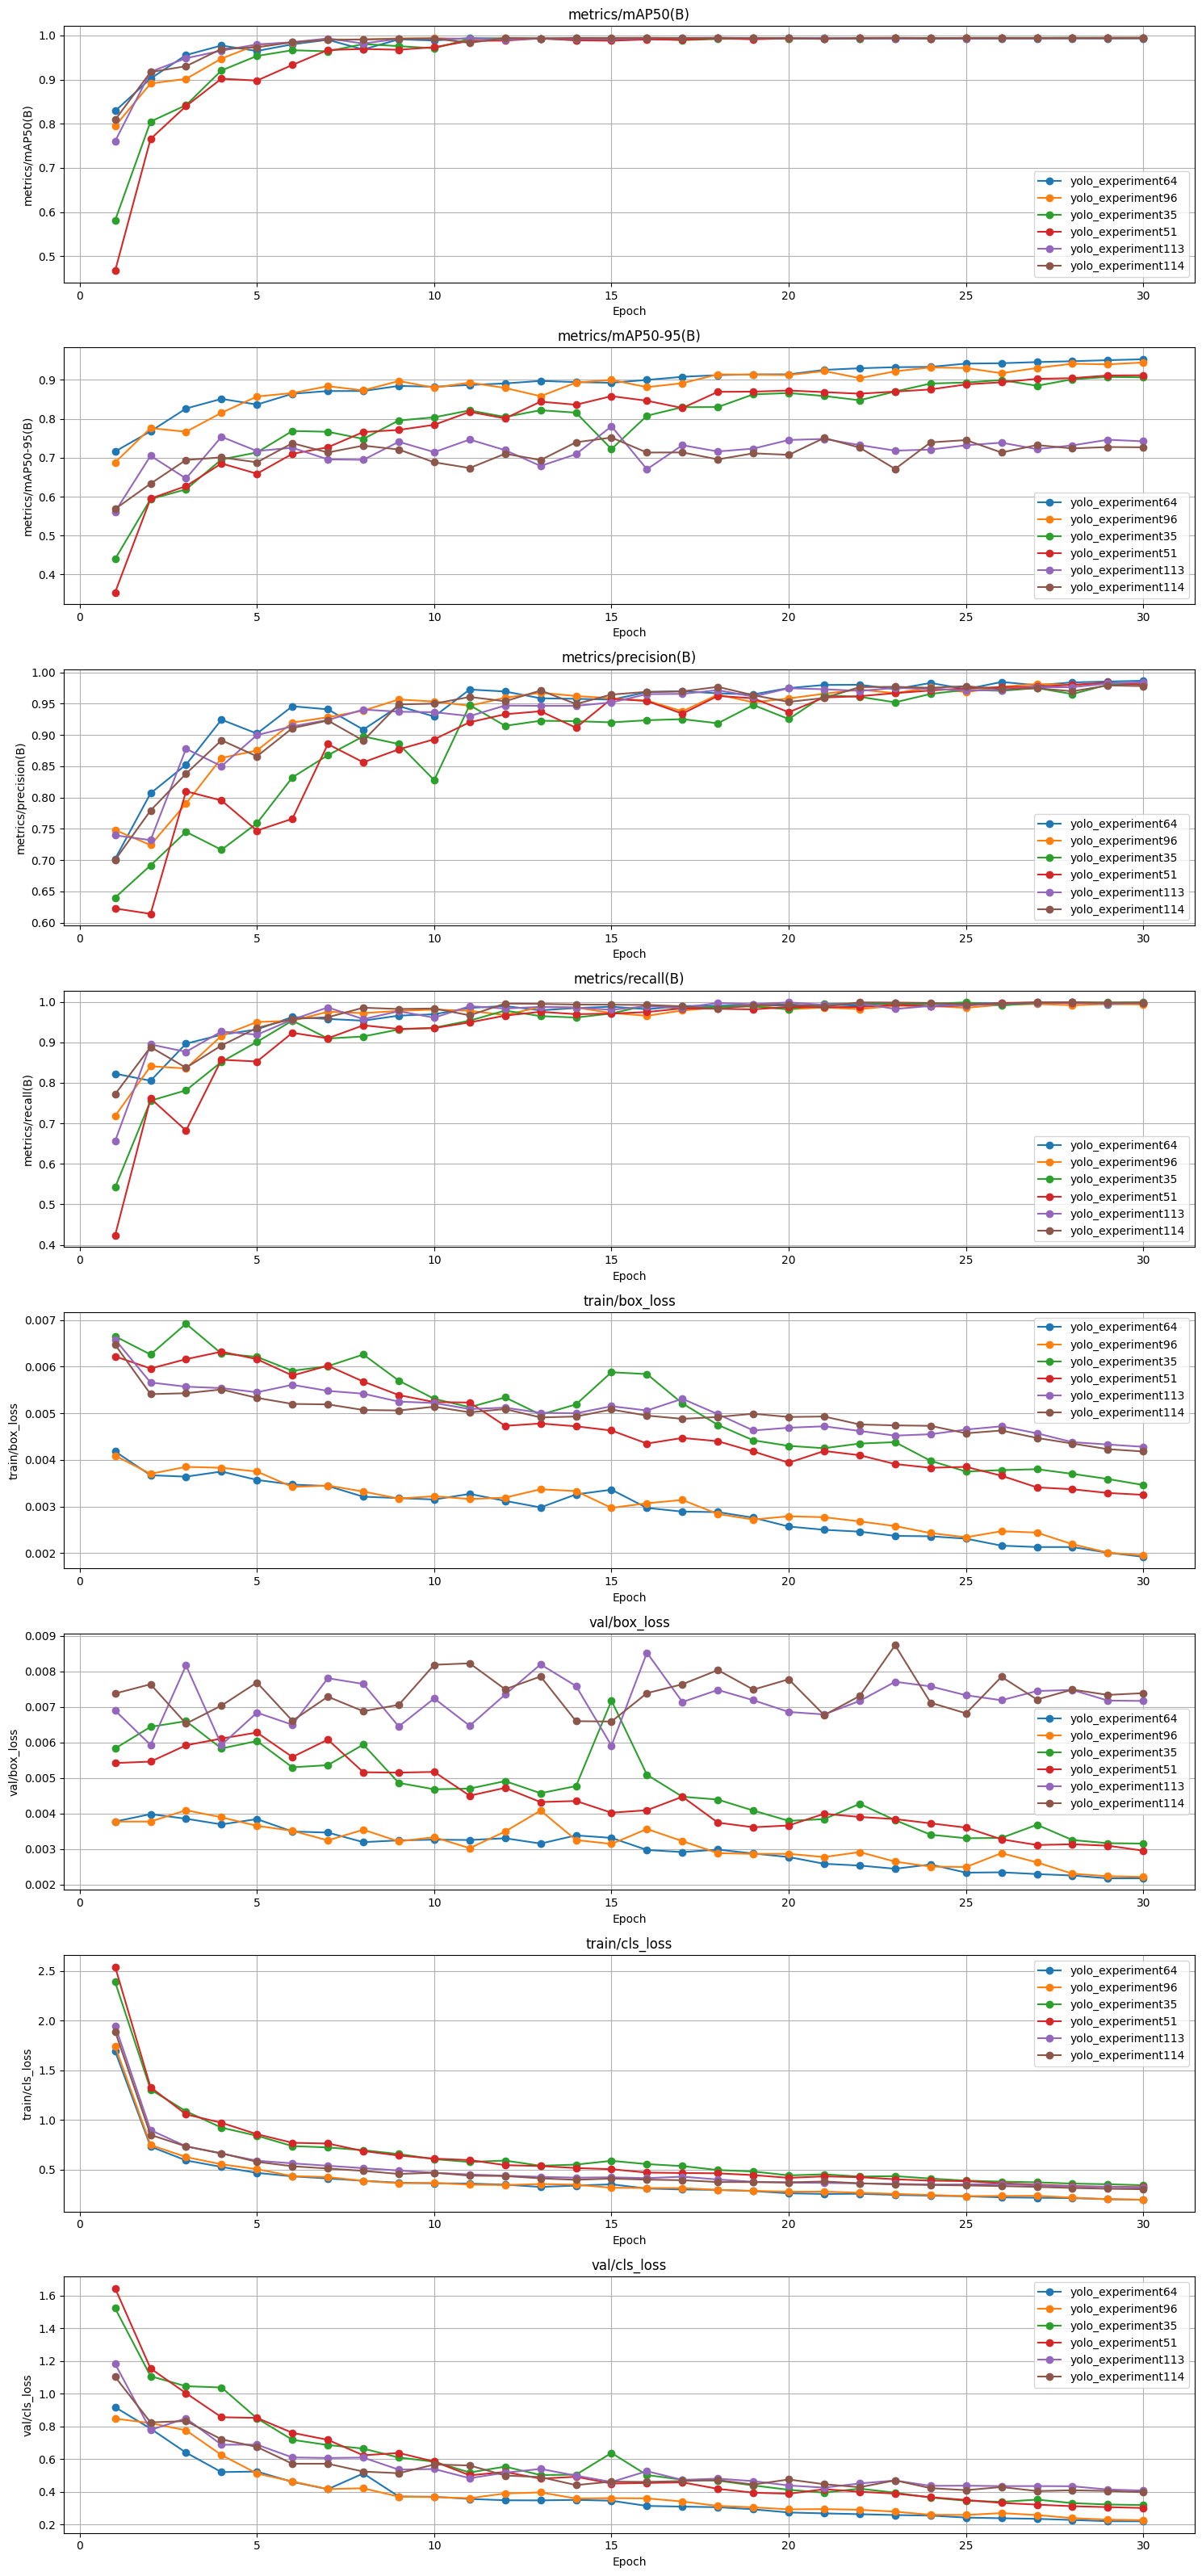

In [34]:
best_dirs = [run_dirs[63], run_dirs[95]]
worst_dirs = [run_dirs[34], run_dirs[50]]
degrees_dirs = run_dirs[-2:]

print("BEST =", combinations[63], combinations[95])
print("WORST =", combinations[34], combinations[50])

compare_yolo_runs(best_dirs + worst_dirs + degrees_dirs)